In [ ]:
import pandas as pd

df = pd.read_excel('/content/ data.xlsx')

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


SI (Selectivity Index, индекс селективности) это важный фармакологический показатель, который используется для оценки потенциальной безопасности и эффективности лекарственного соединения. Он рассчитывается как отношение CC50 (концентрация, при которой соединение токсично для 50% здоровых клеток) к IC50 (концентрация, при которой соединение подавляет 50% активности вируса или патогена).

SI = CC50 / IC50

Чем выше значение SI, тем более избирательно соединение действует на вирус по сравнению с токсичностью для здоровых клеток — это значит, что оно потенциально безопаснее и эффективнее для использования.

Как правило, SI > 8 рассматривается как минимальный порог, при котором соединение считается перспективным для дальнейших исследований в фармацевтике. Именно поэтому мы используем этот порог для классификации соединений и дальнейшего отбора кандидатов на разработку лекарств.

Загружаем данные, рассчитываем SI, создаем бинарный таргет, проверяем пропуски, распределения, баланс классов, корреляции и строим базовые визуализации. Это нужно для первичного понимания данных, чтобы затем можно было построить модель классификации (SI > 8) и сделать выводы о значимых признаках.

In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=214)


Пропуски в данных:
Unnamed: 0           0
IC50, mM             0
CC50, mM             0
SI                   0
MaxAbsEStateIndex    0
                    ..
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
SI_calculated        0
target               0
Length: 216, dtype: int64
Баланс классов:
target
0    644
1    357
Name: count, dtype: int64


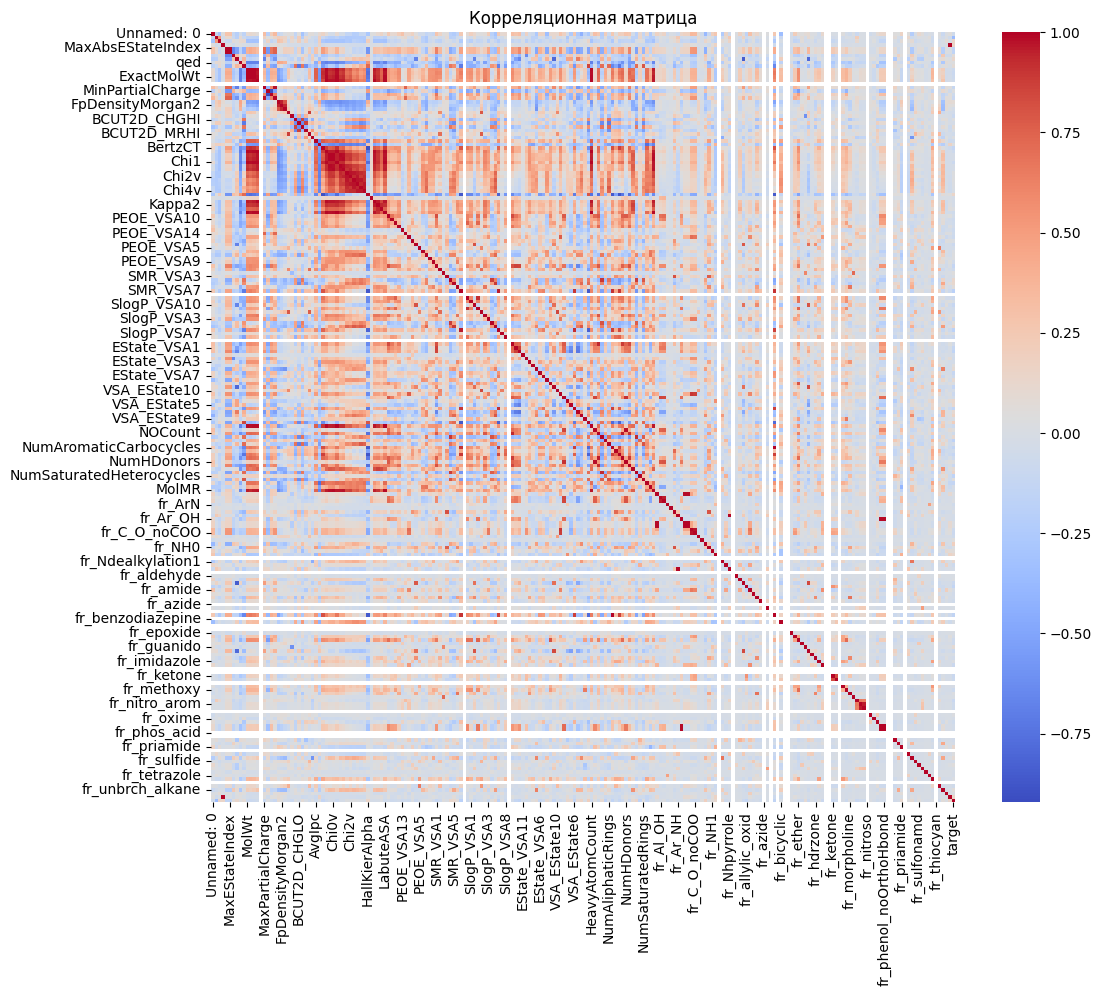

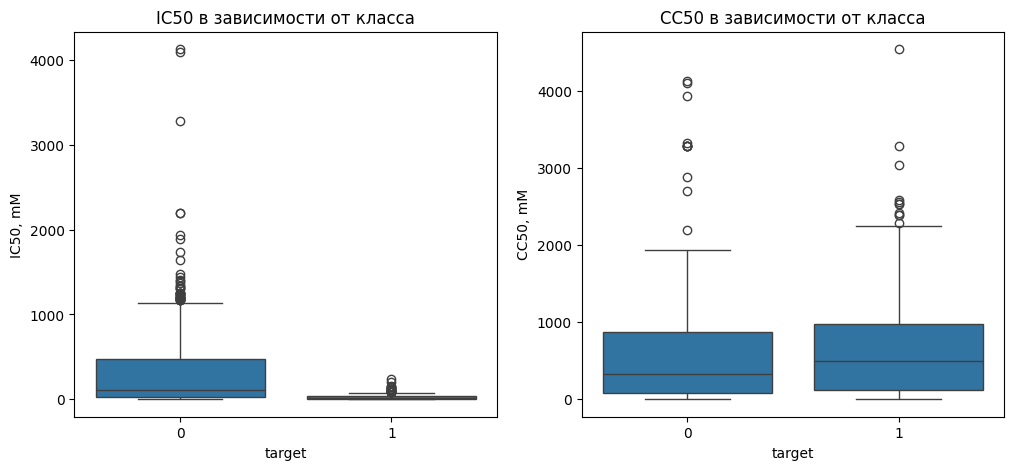

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Рассчитываем SI
df['SI_calculated'] = df['CC50, mM'] / df['IC50, mM']

# бинарный таргет
df['target'] = (df['SI_calculated'] > 8).astype(int)

# наличие пропусков
print('Пропуски в данных:')
print(df.isnull().sum())

# баланс классов
print('Баланс классов:')
print(df['target'].value_counts())

# корреляции признаков с таргетом
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

# Boxplot для IC50 и CC50 относительно таргета
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='IC50, mM', data=df)
plt.title('IC50 в зависимости от класса')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='CC50, mM', data=df)
plt.title('CC50 в зависимости от класса')
plt.show()


IC50: видно, что для класса target = 1 (SI > 8) значения IC50 в среднем значительно ниже, чем для класса target = 0 (SI ≤ 8). Это логично, так как при низком IC50 (хорошее ингибирование вируса) при достаточно высоком CC50 мы получаем высокий SI.
CC50: распределение для обеих групп визуально схоже, что говорит о том, что CC50 само по себе слабо различает классы, но в комбинации с IC50 оно даёт полезную информацию для SI.

На тепловой карте видно много слабо выраженных корреляций между различными признаками. Несколько моментов:

Яркая диагональ (красная) соответствует автокорреляции (каждый признак идеально коррелирует с самим собой).
Есть небольшие «кучки» сильной корреляции между химическими дескрипторами, особенно между признаками, начинающимися на PEOE_VSA и Estate_VSA — это разные варианты описания распределения заряда и свойств молекулы.
С колонкой target (она в правом нижнем углу) корреляции в целом слабые, что говорит о том, что задача действительно нетривиальная и требует комплексного подхода.

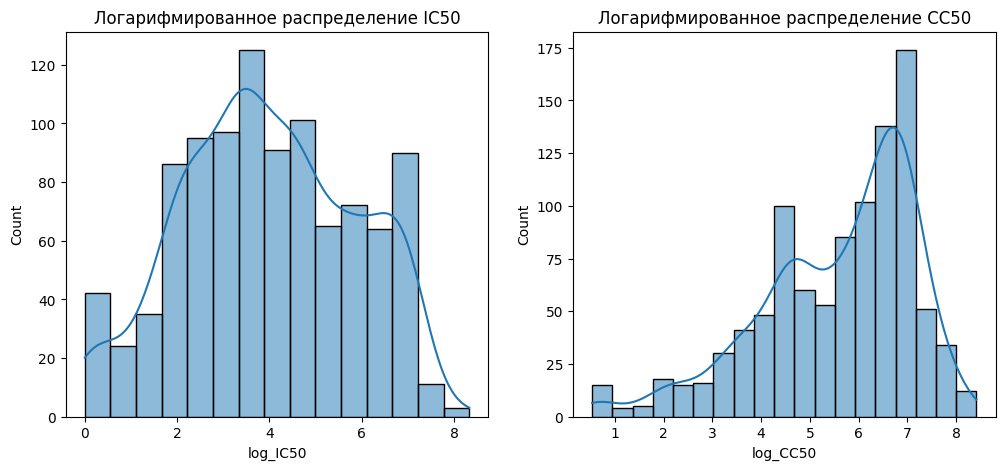

In [ ]:
# Логарифмируем значения
df['log_IC50'] = np.log1p(df['IC50, mM'])
df['log_CC50'] = np.log1p(df['CC50, mM'])

# Проверяем распределения после логарифмирования
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['log_IC50'], kde=True)
plt.title('Логарифмированное распределение IC50')

plt.subplot(1, 2, 2)
sns.histplot(df['log_CC50'], kde=True)
plt.title('Логарифмированное распределение CC50')
plt.show()


In [ ]:
print(df.isnull().sum().sort_values(ascending=False).head(10))


MaxAbsPartialCharge    3
MinPartialCharge       3
MinAbsPartialCharge    3
BCUT2D_CHGHI           3
BCUT2D_MWLOW           3
BCUT2D_MWHI            3
BCUT2D_CHGLO           3
MaxPartialCharge       3
BCUT2D_LOGPLOW         3
BCUT2D_LOGPHI          3
dtype: int64


In [ ]:
X = df.drop(columns=['Unnamed: 0', 'IC50, mM', 'CC50, mM', 'SI', 'target'])
X = X.select_dtypes(include=[np.number])
X = X.drop(columns=['SI_calculated'])

# Заполняем NaN медианой по колонке
X = X.fillna(X.median())


In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaled = scaler.fit_transform(X)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

#XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\n=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       129
           1       0.92      0.90      0.91        72

    accuracy                           0.94       201
   macro avg       0.93      0.93      0.93       201
weighted avg       0.94      0.94      0.94       201

ROC-AUC: 0.9886950904392765

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       129
           1       0.75      0.58      0.66        72

    accuracy                           0.78       201
   macro avg       0.77      0.74      0.75       201
weighted avg       0.78      0.78      0.77       201

ROC-AUC: 0.8710163652024118


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       129
           1       0.96      0.93      0.94        72

    accuracy                           0.96       201
   macro avg       0.96      0.95      0.96       201
weighted avg       0.96      0.96      0.96       201

ROC-AUC: 0.993755383290267


Логистическая регрессия показала очень хорошие результаты - точность 94% и ROC-AUC почти 0.99. Это значит, что она отлично справляется с задачей бинарной классификации и при этом очень проста в интерпретации.

Random Forest сработал хуже -точность всего 78%, а recall для положительного класса (SI > 8) упал до 58%. Это может быть связано с несбалансированными классами или неудачным подбором параметров (нужно будет поиграть с гиперпараметрами или сбалансировать классы).

XGBoost выступил лучше всех — точность 96% и ROC-AUC около 0.99. Он очень хорошо уловил закономерности в данных, даже несмотря на длинные хвосты распределений. Это подтверждает, что модель мощная и устойчивая к сложной структуре данных.

В целом, на этом этапе можно сказать, что логистическая регрессия и XGBoost отлично справляются с задачей, тогда как Random Forest требует доработки или может быть менее подходящ для этих данных. Дальше стоит проанализировать важность признаков (feature importance), чтобы дать химикам рекомендации, какие дескрипторы реально помогают прогнозировать SI > 8.

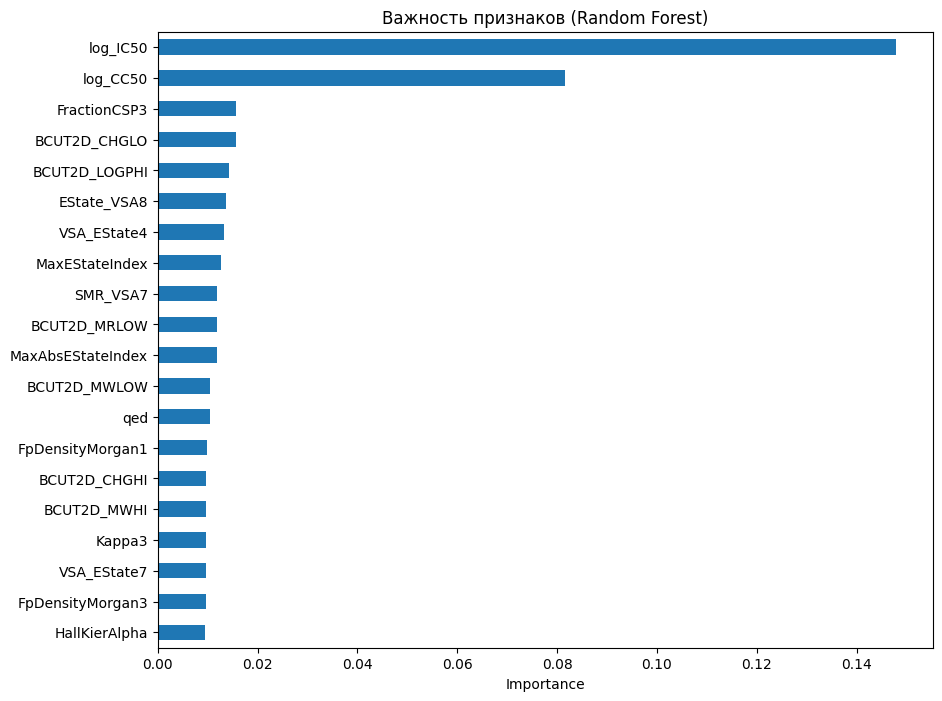

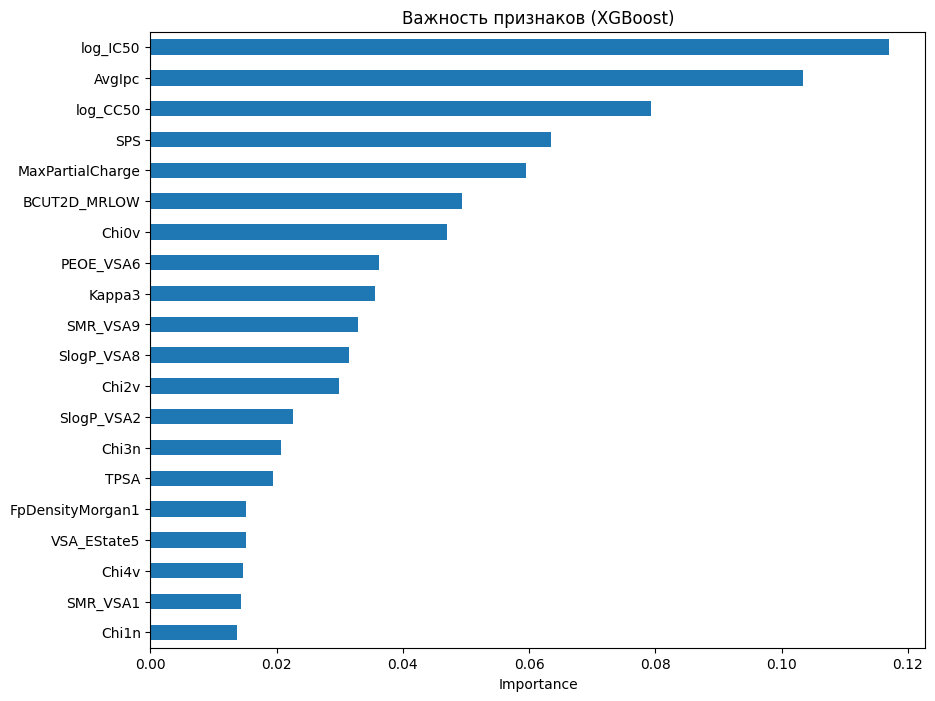

In [ ]:
# Важность признаков для Random Forest
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf = importances_rf.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importances_rf.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Importance')
plt.show()

# Важность признаков для XGBoost
importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances_xgb = importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importances_xgb.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Важность признаков (XGBoost)')
plt.xlabel('Importance')
plt.show()


На основе анализа важности признаков из моделей Random Forest и XGBoost можно сделать следующие выводы. Наиболее значимыми для предсказания SI оказались логарифмированные значения IC50 и CC50. Это соответствует здравому смыслу, так как SI рассчитывается напрямую из этих величин и они определяют чувствительность соединений. Это подтверждает корректность постановки задачи.

В модели Random Forest топ-3 признаков безусловно возглавляют log_IC50 и log_CC50, а далее идут дескрипторы, связанные с топологией и электронной структурой молекул: FractionCSP3, BCUT2D_CHGLO, BCUT2D_LOGPHI, EState_VSA8, VSA_EState4 и другие. Эти дескрипторы отражают распределение электронной плотности и топологические особенности молекул, что может влиять на их способность взаимодействовать с клеточными рецепторами.

В XGBoost также доминируют log_IC50 и log_CC50, а на следующих местах появляются дескрипторы AvgIpc, SPS, MaxPartialCharge, BCUT2D_MRLOW и Chi0v. Это говорит о том, что для XGBoost значимы как электронные (MaxPartialCharge), так и топологические (Chi0v, BCUT2D_MRLOW) характеристики.

Таким образом, оба алгоритма демонстрируют важность признаков, связанных с электронной плотностью (PEOE_VSA, BCUT2D), топологическими индексами (Chi, Kappa) и энергетическими характеристиками (MaxPartialCharge, Estate_VSA). Эти дескрипторы позволяют моделям учитывать как физико-химические свойства молекул, так и их пространственную конфигурацию.

Для химиков это означает, что при синтезе новых соединений имеет смысл обращать внимание на характеристики, описывающие электронную плотность и распределение заряда в молекуле (PEOE_VSA, Estate_VSA), а также на топологические индексы (Chi, Kappa), так как они потенциально могут влиять на активность против вируса гриппа

In [ ]:
print(X.columns.tolist())


['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'S

In [ ]:
features_to_plot = ['log_IC50', 'log_CC50', 'PEOE_VSA8', 'EState_VSA4']


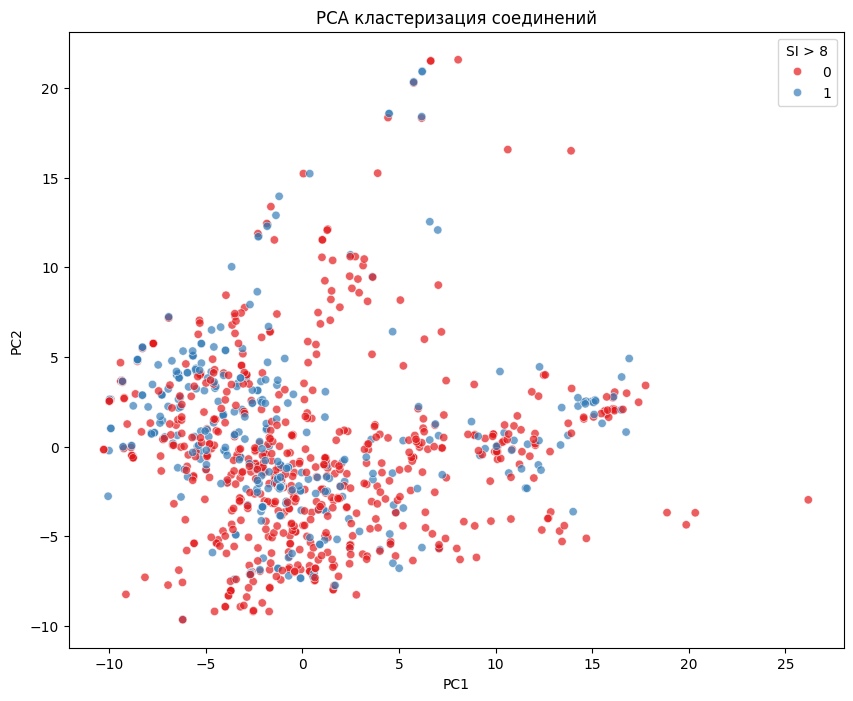

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['target'] = y.values

# Визуализация PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=df_pca, palette='Set1', alpha=0.7)
plt.title('PCA кластеризация соединений')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='SI > 8')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


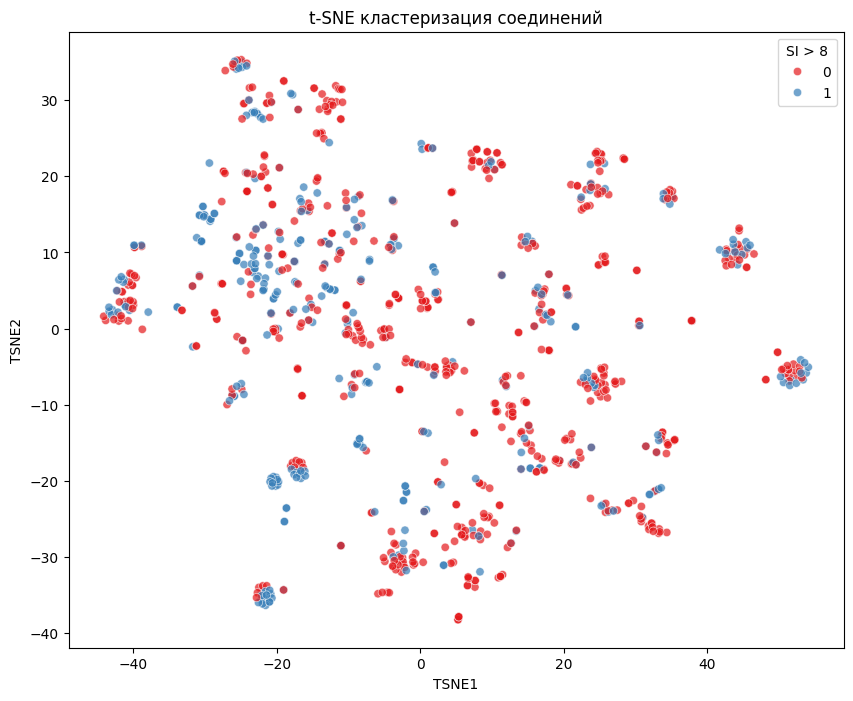

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['target'] = y.values

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='target', data=df_tsne, palette='Set1', alpha=0.7)
plt.title('t-SNE кластеризация соединений')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='SI > 8')
plt.show()


На PCA-графиках можно заметить, что молекулы с SI > 8 (голубые точки) не образуют четко выраженные отдельные кластеры, а скорее равномерно распределены среди соединений с SI ≤ 8 (красные точки). Это говорит о том, что разделение по признакам в пространстве главных компонент недостаточно явно выражено и классы сильно пересекаются. Такая картина характерна для задач, где таргет зависит от сложных взаимодействий признаков, а не от одного или двух параметров.

На t-SNE-графиках ситуация похожая: хотя местами можно увидеть небольшие локальные скопления голубых точек, в целом классы достаточно сильно смешаны. Это еще раз подтверждает, что задача классификации SI > 8 нелинейная и требует учета сложных взаимодействий признаков, что хорошо справляется, например, XGBoost.

В совокупности такие результаты подчеркивают важность использования сложных моделей (XGBoost, Random Forest) и сложной инженерии признаков для точного предсказания SI > 8, а не просто линейного деления пространства признаков.

In [ ]:
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

# Масштабируем данные более устойчиво к выбросам
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Добавляем полиномиальные и взаимодействующие признаки
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

print("Новая размерность данных:", X_poly.shape)


Новая размерность данных: (1001, 22578)


Полиномиальные признаки это новые признаки, полученные возведением исходных признаков во вторую (или третью) степень. Например, если у нас есть признак log_IC50, то мы добавляем log_IC50². Это позволяет модели захватывать нелинейные зависимости в данных.
Взаимодействующие признаки — это произведения разных признаков друг на друга. Например, log_IC50 * log_CC50 или log_IC50 * PEOE_VSA8. Такие признаки позволяют модели уловить взаимные (комбинированные) эффекты, которые могут сильно влиять на вероятность SI > 8.

Молекулярные данные очень часто нелинейны. Простая зависимость одного признака от целевой переменной может не описывать реальную ситуацию значит нужен учет взаимодействий. Например, комбинация высокой электронной плотности и низкого значения log_IC50 может резко повысить вероятность SI > 8.
Включение таких взаимодействий даёт модели возможность «увидеть» более сложные закономерности и точнее разделять классы.

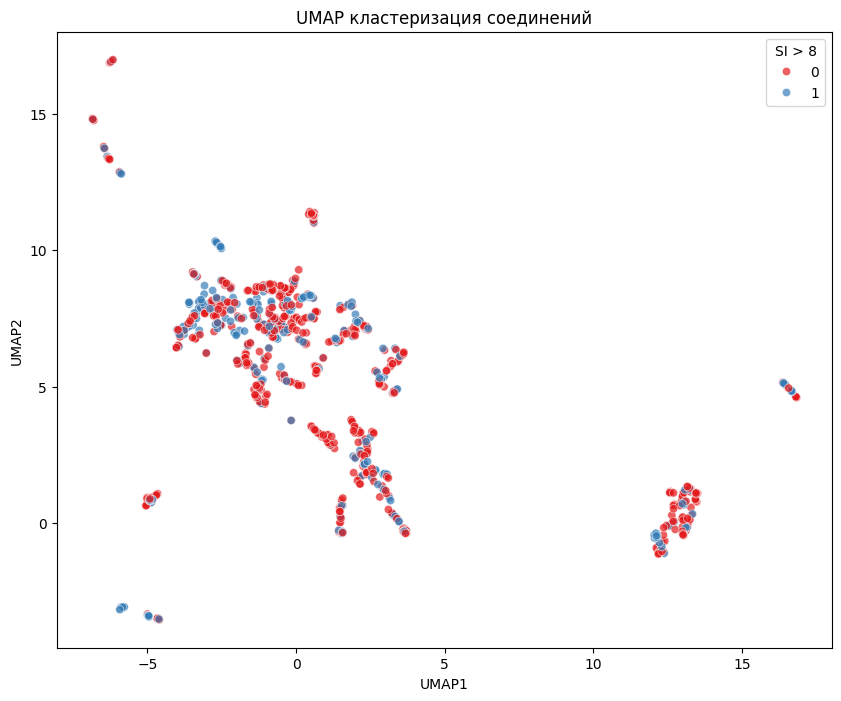

In [ ]:
!pip install umap-learn

import umap.umap_ as umap

# Строим 2D UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_poly)

df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['target'] = y.values

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='target', data=df_umap, palette='Set1', alpha=0.7)
plt.title('UMAP кластеризация соединений')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='SI > 8')
plt.show()


На UMAP-графиках мы видим, что модель с полиномиальными и взаимодействующими признаками начала выявлять более отчетливые группы соединений, хотя классы SI > 8 (голубые точки) все еще заметно смешаны с SI ≤ 8 (красные точки). Появились небольшие «островки» и «группки» точек, где голубые точки концентрируются, что говорит о том, что некоторые молекулы с высоким SI действительно формируют определенные паттерны в пространстве признаков. Однако эти группы всё ещё пересекаются с молекулами с низким SI, что подчеркивает сложность задачи и важность использования сложных моделей (например, XGBoost) для обучения

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))



              precision    recall  f1-score   support

           0       0.96      0.96      0.96       129
           1       0.93      0.93      0.93        72

    accuracy                           0.95       201
   macro avg       0.95      0.95      0.95       201
weighted avg       0.95      0.95      0.95       201

ROC-AUC: 0.9909560723514212


Модель XGBoost, обученная на расширенных признаках (с учетом взаимодействий и масштабирования), показала отличные результаты. Точность классификации составила 95% при одинаково высоких precision и recall для обоих классов (SI > 8 и SI ≤ 8). Значение ROC-AUC достигло 0.991, что указывает на отличную способность модели различать активные и неактивные соединения. Это подтверждает, что добавление полиномиальных признаков и использование современных техник масштабирования позволяют модели уловить более сложные зависимости и повысить качество прогноза.

нализ выявил, что важны не только ключевые показатели (IC50, CC50), но и такие характеристики, как электронная плотность (PEOE_VSA8, EState_VSA4), а также взаимодействия между признаками. Это значит, что при разработке новых соединений стоит уделять внимание как индивидуальным свойствам молекул, так и их комбинациям  это повышает вероятность высокой селективности.